<a href="https://colab.research.google.com/github/koerding/ApplyingToLabs/blob/main/projects/neurons/load_stringer_spontaneous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [1]:
# @title Install dependencies
!pip install umap-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [3]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [5]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


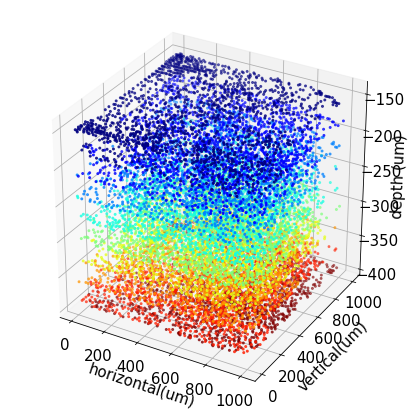

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

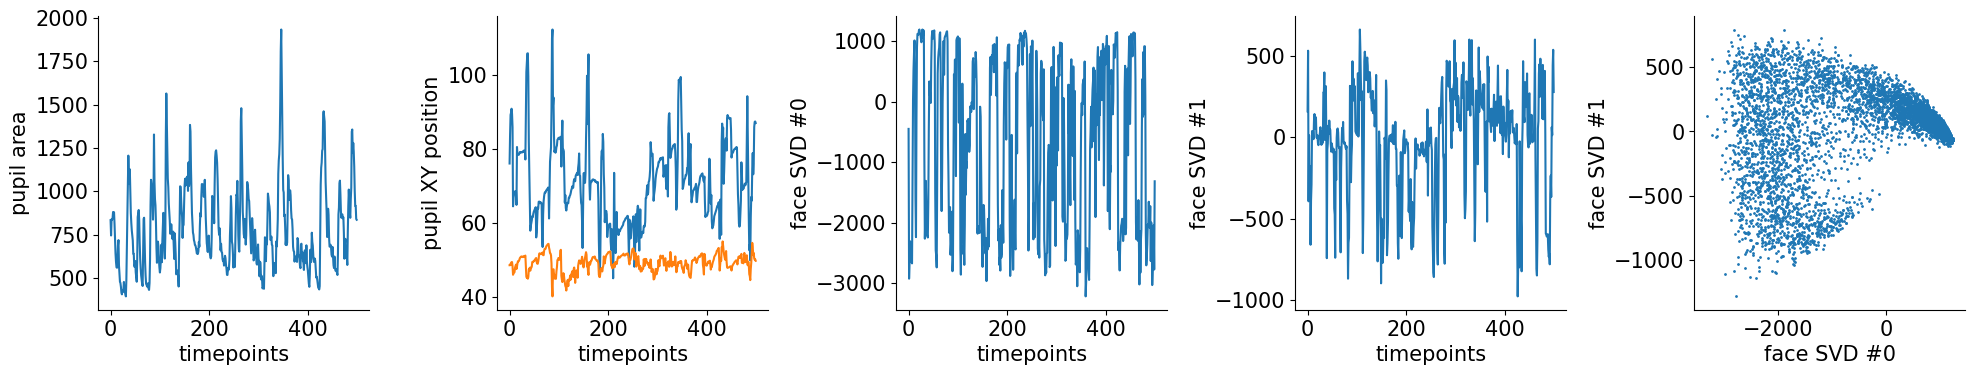

In [6]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [14]:
pca = PCA(n_components=2000)
transformed_data = pca.fit_transform(Z)  # Get the transformed data
explained_variance = pca.explained_variance_ratio_  # Get the explained variance


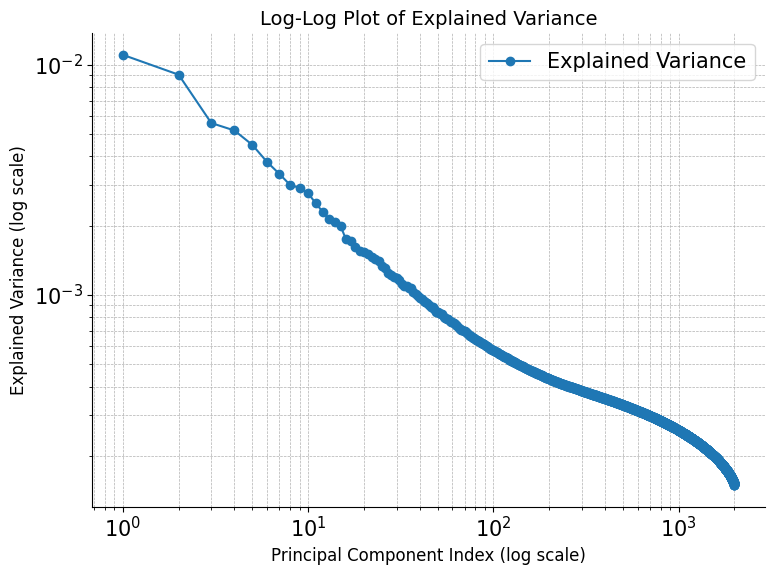

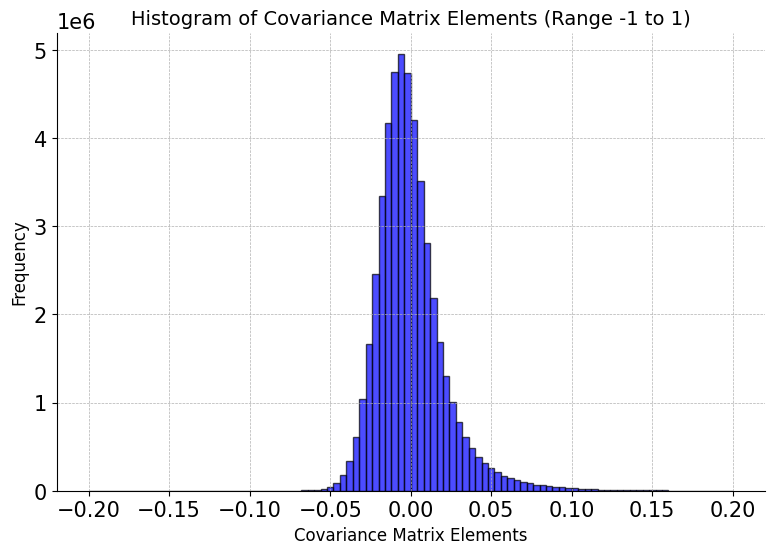

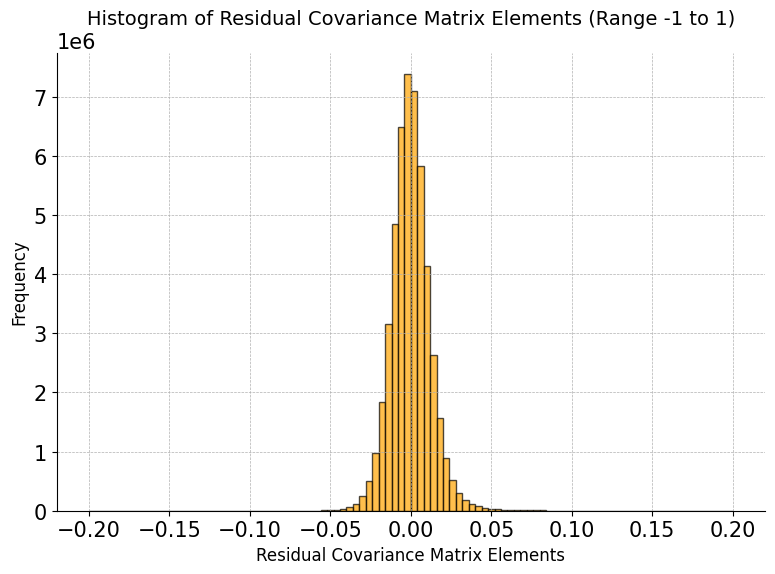

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `explained_variance` is already computed from PCA
x_values = np.arange(1, len(explained_variance) + 1)  # Principal component indices
y_values = explained_variance  # Explained variance ratios

# Create a log-log plot
plt.figure(figsize=(8, 6))
plt.loglog(x_values, y_values, marker='o', linestyle='-', label='Explained Variance')

# Add labels and title
plt.xlabel('Principal Component Index (log scale)', fontsize=12)
plt.ylabel('Explained Variance (log scale)', fontsize=12)
plt.title('Log-Log Plot of Explained Variance', fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.show()

# Compute the covariance matrix of the original data
cov_matrix = np.cov(Z, rowvar=False)  # Z is the z-scored data
cov_elements = cov_matrix.flatten()  # Flatten the covariance matrix to get all elements

# Plot the histogram with range -1 to 1 and 100 bins
plt.figure(figsize=(8, 6))
plt.hist(cov_elements, bins=np.linspace(-0.2, 0.2, 101), alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Covariance Matrix Elements', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Covariance Matrix Elements (Range -1 to 1)', fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Project the data onto the largest 10 PCs
top_10_pcs = pca.components_[:10]  # Top 10 principal components
residual_data = Z - Z @ top_10_pcs.T @ top_10_pcs  # Remove contribution of top 10 PCs

# Compute the covariance matrix of the residual data
residual_cov_matrix = np.cov(residual_data, rowvar=False)
residual_cov_elements = residual_cov_matrix.flatten()

# Plot the histogram with range -1 to 1 and 100 bins
plt.figure(figsize=(8, 6))
plt.hist(residual_cov_elements, bins=np.linspace(-0.2, 0.2, 101), alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residual Covariance Matrix Elements', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Residual Covariance Matrix Elements (Range -1 to 1)', fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()




In [12]:
# prompt: the previous cell runs pca and stores it as X, can you also calculate the variance explained associated with each PC

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

NameError: name 'pca' is not defined

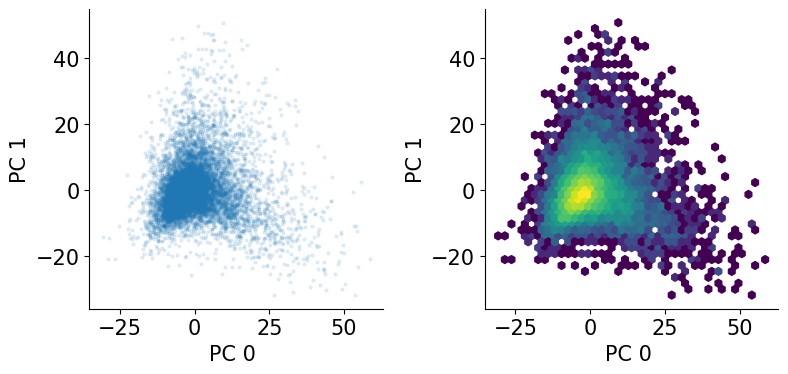

In [8]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

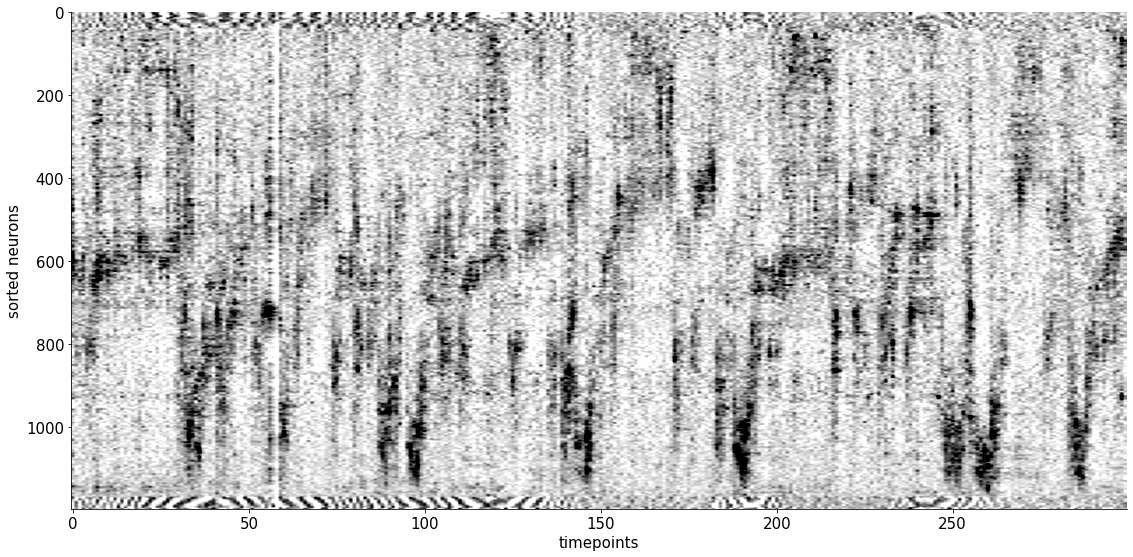

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture